<a href="https://colab.research.google.com/github/anushil-dev/Fake_News_Detection/blob/main/ML_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Block 1: Import Tools (Updated)
import pandas as pd
import numpy as np
import itertools
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

print("Tools loaded! 🚀")

Tools loaded! 🚀


In [14]:
# Block 2: Download NLTK Data (New)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

print("Dictionaries downloaded! 📚")

Dictionaries downloaded! 📚


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [15]:
# Block 2: Upload Files
from google.colab import files
uploaded = files.upload()

print("Files uploaded! Let's analyze them.")

Files uploaded! Let's analyze them.


🔎 Checking data quality...

Missing Values:
Statement        0
Label        12794
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15362 entries, 0 to 15361
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Statement  15362 non-null  object 
 1   Label      2568 non-null   float64
dtypes: float64(1), object(1)
memory usage: 240.2+ KB

Check finished. ✅


/tmp/ipython-input-3819504967.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=total_data, palette='hls')


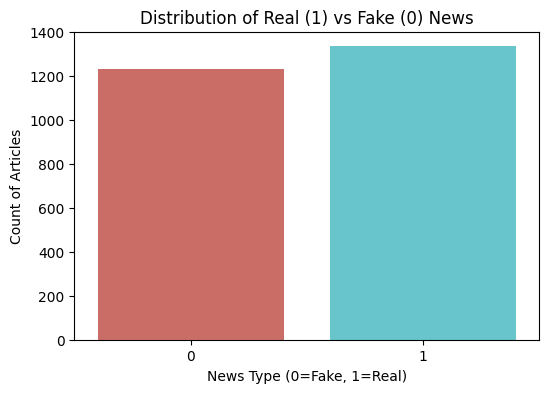


First 10 rows of RAW data:


,Statement,Label
0,40% of Americans know someone who has been kil...,1
10,Public display of a long rifle is perfectly le...,1
17,Says Robert Hurt supports the tax loopholes th...,0
26,Says that President Obama said in 2008 that hi...,1
28,Says Hillary Clinton has been saying lately th...,0
38,"Unlike virtually every other campaign, we dont...",1
44,There have been more terrorist attacks on U.S....,1
50,Says Robert Hurt supports the tax loopholes th...,0
53,"Under current U.S. immigration policy, literal...",0
66,The Romney-Ryan plan for Medicare does not aff...,1


In [16]:
# Block 3: Load, Combine, and Quality Check
# 1. Load data
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
df3 = pd.read_csv('valid.csv')

# 2. Combine and Shuffle
total_data = pd.concat([df1, df2, df3], ignore_index=True)
total_data = total_data.sample(frac=1).reset_index(drop=True)

# 3. Fix Labels (TRUE->1, FALSE->0)
label_mapping = {
    'TRUE': 1, 'True': 1, 'true': 1,
    'FALSE': 0, 'False': 0, 'false': 0
}
total_data['Label'] = total_data['Label'].map(label_mapping)

# --- QUALITY CHECK SECTION ---
def data_qualityCheck():
    print("🔎 Checking data quality...")

    # Check 1: Are there empty rows?
    missing_values = total_data.isnull().sum()
    print("\nMissing Values:")
    print(missing_values)

    # Check 2: Data Types (Do we have numbers or text?)
    print("\nData Info:")
    total_data.info()

    print("\nCheck finished. ✅")

# Run the check
data_qualityCheck()

# Drop bad rows after checking
total_data = total_data.dropna(subset=['Label'])
total_data['Label'] = total_data['Label'].astype(int)

# Diagram: Real vs Fake Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=total_data, palette='hls')
plt.title("Distribution of Real (1) vs Fake (0) News")
plt.xlabel("News Type (0=Fake, 1=Real)")
plt.ylabel("Count of Articles")
plt.show()

# Show the first 10 rows as you asked
print("\nFirst 10 rows of RAW data:")
display(total_data.head(10))

In [17]:
# Block 5: Advanced Cleaning (Updated)
# Initialize the NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_cleaning(text):
    text = str(text).lower()

    # 1. Regex: Keep letters and numbers
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 2. Tokenize (Split into words)
    words = text.split()

    # 3. Lemmatization & Stopwords
    # This turns "running" -> "run" and removes "the", "is", etc.
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(cleaned_words)

# Apply the new function
print("Cleaning data... (This might take a moment)")
total_data['Statement'] = total_data['Statement'].apply(advanced_cleaning)

print("Data Cleaned with Logic! 🧠")
display(total_data.head())

Cleaning data... (This might take a moment)
Data Cleaned with Logic! 🧠


,Statement,Label
0,40 american know someone killed gun,1
10,public display long rifle perfectly legal texas,1
17,say robert hurt support tax loophole send amer...,0
26,say president obama said 2008 proposed greenho...,1
28,say hillary clinton saying lately think qualif...,0


Generating Word Matrix... This may take a moment. ⏳


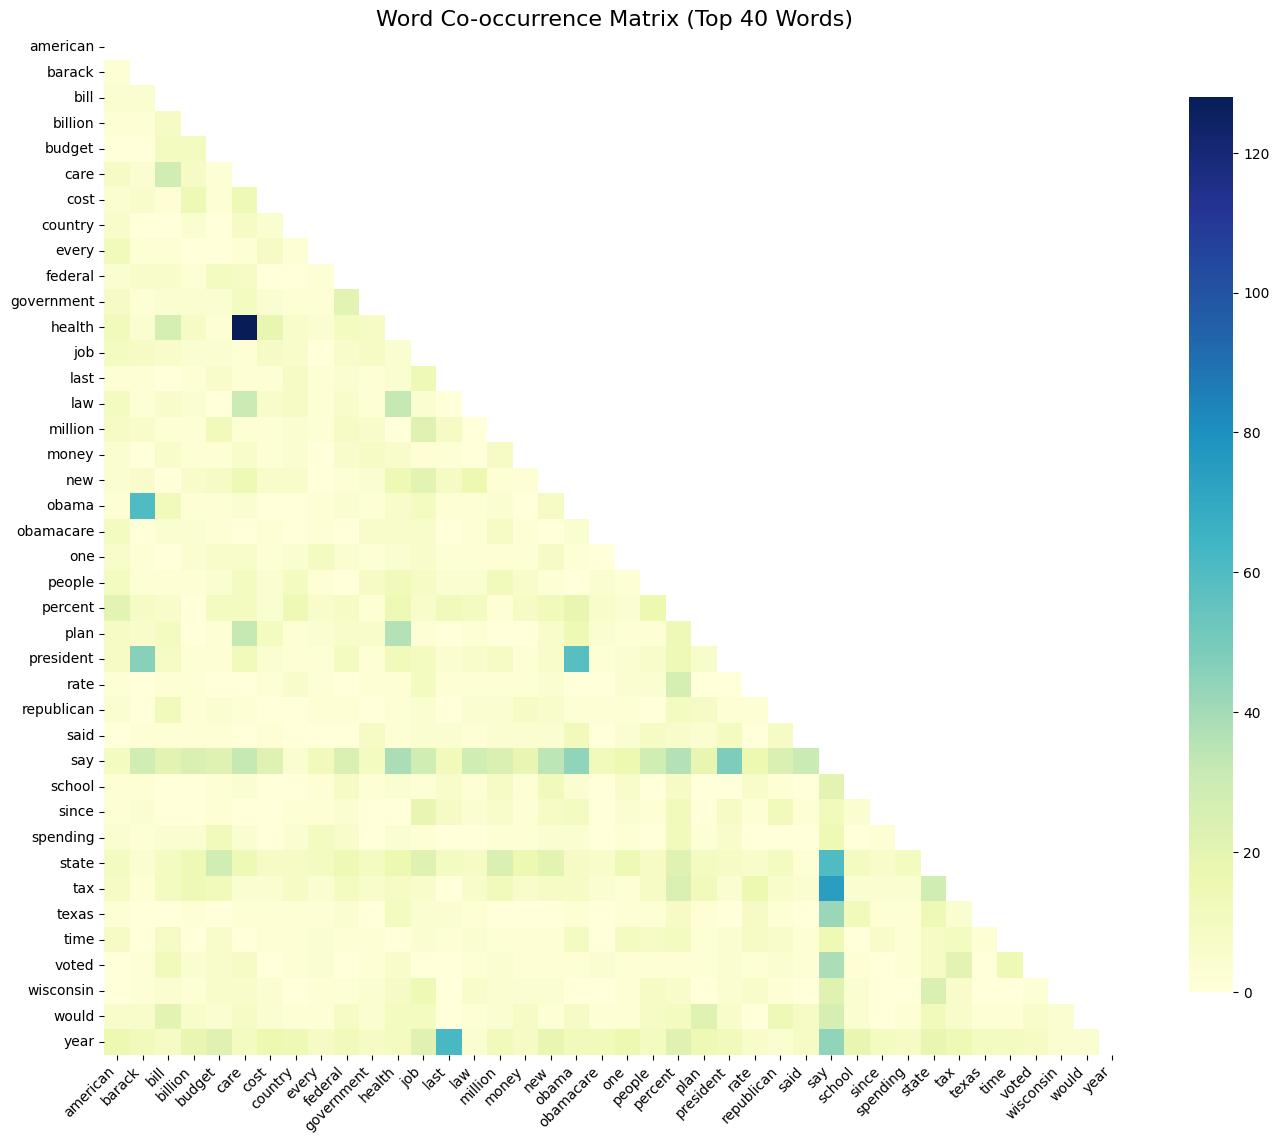

Word Matrix Generated! 📊


In [18]:
# --- WORD CO-OCCURRENCE MATRIX ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

print("Generating Word Matrix... This may take a moment. ⏳")

# 1. Get the cleaned text corpus
corpus = total_data['Statement'].tolist()

# 2. Use CountVectorizer to build the co-occurrence matrix
# We'll look at the top 40 words for a detailed yet readable grid.
# We use binary=True because we only care IF they appear together, not how many times.
top_n_words = 40
vectorizer_matrix = CountVectorizer(max_features=top_n_words, binary=True)
X = vectorizer_matrix.fit_transform(corpus)

# 3. Calculate the Co-occurrence Matrix (X transpose * X)
# This is a standard mathematical method to find co-occurrences.
# The resulting matrix C[i, j] is the number of documents containing both word i and word j.
co_occurrence_matrix = (X.T * X)

# Set diagonal to 0 (we don't care about a word appearing with itself)
co_occurrence_matrix.setdiag(0)

# 4. Convert to a Pandas DataFrame for easier plotting
word_list = vectorizer_matrix.get_feature_names_out()
df_matrix = pd.DataFrame(co_occurrence_matrix.toarray(), index=word_list, columns=word_list)

# 5. Plot the Heatmap
plt.figure(figsize=(14, 12))

# Use a mask to only show the lower half of the matrix (since it's mirrored)
# This makes the chart cleaner and easier to read.
mask = np.triu(np.ones_like(df_matrix, dtype=bool))

# Create the heatmap
# cmap="YlGnBu" gives a nice yellow-to-blue color scheme.
sns.heatmap(df_matrix, annot=False, mask=mask, cmap="YlGnBu", square=True, cbar_kws={"shrink": .8})

# Add labels and title
plt.title(f"Word Co-occurrence Matrix (Top {top_n_words} Words)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

print("Word Matrix Generated! 📊")

In [19]:
# Block 5: Vectorization (N-Grams)
# 1. Split Data
x_train, x_test, y_train, y_test = train_test_split(total_data['Statement'], total_data['Label'], test_size=0.2, random_state=42)

# 2. Create Vectorizer (Look at 1 word and 2-word pairs)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# 3. Fit and Transform
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print("Translation complete. Ready to train.")

Translation complete. Ready to train.


In [20]:
# Block 6: Train Model
model = PassiveAggressiveClassifier(max_iter=50)
model.fit(tfidf_train, y_train)

print("Model trained successfully! 🎓")

Model trained successfully! 🎓


🎯 Accuracy: 94.55%


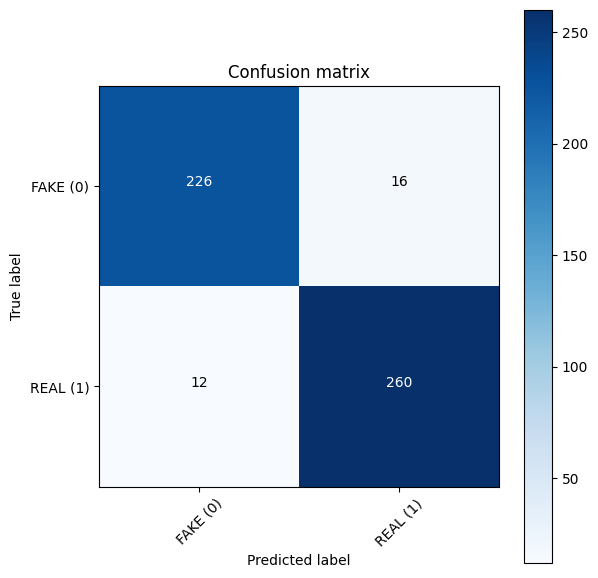

In [21]:
# Block 7: Advanced Visualization (Updated)
# 1. Predict
y_pred = model.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'🎯 Accuracy: {round(score*100, 2)}%')

# 2. Define Custom Plot Function
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3. Show Plot
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=['FAKE (0)', 'REAL (1)'])
plt.show()

In [22]:
# Block 8: Manual Testing System
def manual_testing(news):
    # Prepare data
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(advanced_cleaning)
    new_x_test = new_def_test["text"]

    # Translate
    new_xv_test = vectorizer.transform(new_x_test)

    # Predict
    pred = model.predict(new_xv_test)

    return "Result: REAL News ✅" if pred[0] == 1 else "Result: FAKE News ⚠️"

# Interactive Input
user_input = input("Paste a news headline here to test: ")
print(manual_testing(user_input))

Paste a news headline here to test: PM Modi's gifts to Putin span from Kashmir to Bengal and beyond, list includes special copy of Gita
Result: REAL News ✅


In [23]:
# Block 10: Save the Brain & Translator
import pickle

# 1. Save the Model (The Brain)
filename = 'final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# 2. Save the Vectorizer (The Translator)
# You MUST save this too, or the model won't understand new words later!
pickle.dump(vectorizer, open('final_vectorizer.pkl', 'wb'))

print("✅ Success! Model and Vectorizer saved.")
print("You can download them from the 'Files' tab on the left.")

✅ Success! Model and Vectorizer saved.
You can download them from the 'Files' tab on the left.
